# MediaPipe 작업을 통한 얼굴 감지

이 노트북은 MediaPipe Tasks Python API를 사용하여 이미지에서 얼굴을 감지하는 방법을 보여줍니다.

## 준비

MediaPipe 설치부터 시작해 보겠습니다.

In [1]:
!pip install mediapipe==0.10.13

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 18.2 MB/s eta 0:00:00
  Attempting uninstall: mediapipe
    Found existing installation: mediapipe 0.10.21
    Uninstalling mediapipe-0.10.21:
      Successfully uninstalled mediapipe-0.10.21


그런 다음 기성 모델을 다운로드하십시오. 사용할 수 있는 더 많은 얼굴 감지 모델을 보려면 [MediaPipe 문서](https://developers.google.com/mediapipe/solutions/vision/face_Detector#models)를 확인하세요.

In [2]:
!wget -q -O detector.tflite -q https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/1/blaze_face_short_range.tflite

## 시각화 유틸리티

Face Detector API를 더 잘 보여주기 위해 이 Colab에서 사용할 시각화 도구 세트를 만들었습니다. 그러면 감지된 얼굴 주위에 경계 상자가 그려지고 얼굴에서 감지된 특정 지점 위에 마커가 그려집니다.

In [3]:
from typing import Tuple, Union
import math
import cv2
import numpy as np

MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> Union[None, Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px


def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes and keypoints on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  annotated_image = image.copy()
  height, width, _ = image.shape

  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(annotated_image, start_point, end_point, TEXT_COLOR, 3)

    # Draw keypoints
    for keypoint in detection.keypoints:
      keypoint_px = _normalized_to_pixel_coordinates(keypoint.x, keypoint.y,
                                                     width, height)
      color, thickness, radius = (0, 255, 0), 2, 2
      cv2.circle(annotated_image, keypoint_px, thickness, color, radius)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    category_name = '' if category_name is None else category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(annotated_image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return annotated_image

## 테스트 이미지 다운로드

얼굴 감지를 시연하기 위해 다음 코드를 사용하여 샘플 이미지를 다운로드할 수 있습니다. 크레딧: https://pixabay.com/photos/brother-sister-girl-family-boy-977170/

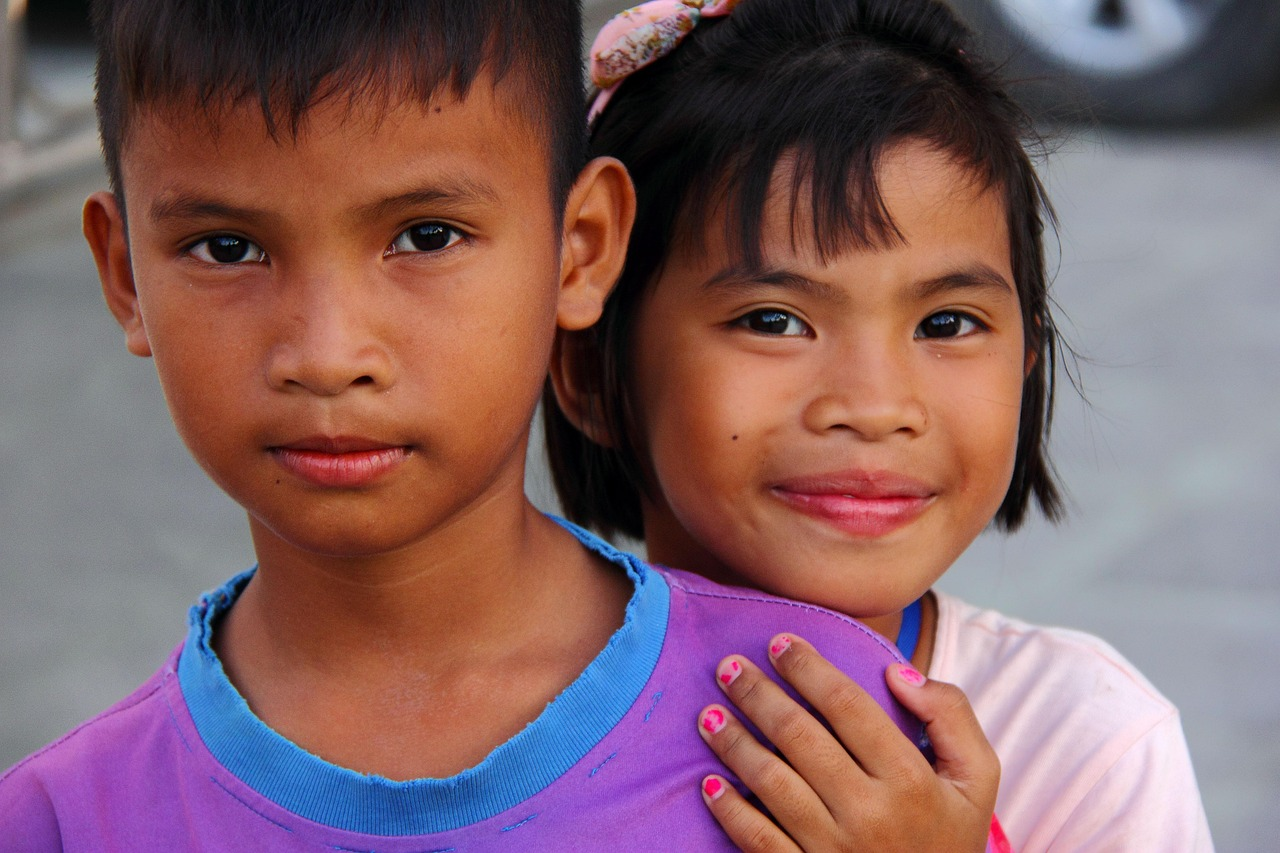

In [5]:
!wget -q -O image.jpg https://cdn.pixabay.com/photo/2015/10/08/05/06/brother-977170_1280.jpg
IMAGE_FILE = 'image.jpg'

import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread(IMAGE_FILE)
cv2_imshow(img)

선택적으로 컴퓨터에서 자신만의 이미지를 업로드할 수 있습니다. 이렇게 하려면 다음 코드 셀의 주석 처리를 제거하세요.

In [ ]:
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded:
#   content = uploaded[filename]
#   with open(filename, 'wb') as f:
#     f.write(content)

# if len(uploaded.keys()):
#   IMAGE_FILE = next(iter(uploaded))
#   print('Uploaded file:', IMAGE_FILE)

## 추론 실행 및 결과 시각화

마지막 단계는 선택한 이미지에서 얼굴 감지를 실행하는 것입니다. 여기에는 FaceDetector 개체 생성, 이미지 로드, 감지 실행, 마지막으로 시각화를 통해 이미지를 표시하는 선택적 단계가 포함됩니다.

이 솔루션이 지원하는 구성 옵션에 대해 자세히 알아보려면 [MediaPipe 문서](https://developers.google.com/mediapipe/solutions/vision/face_Detector/python)를 확인하세요.

/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


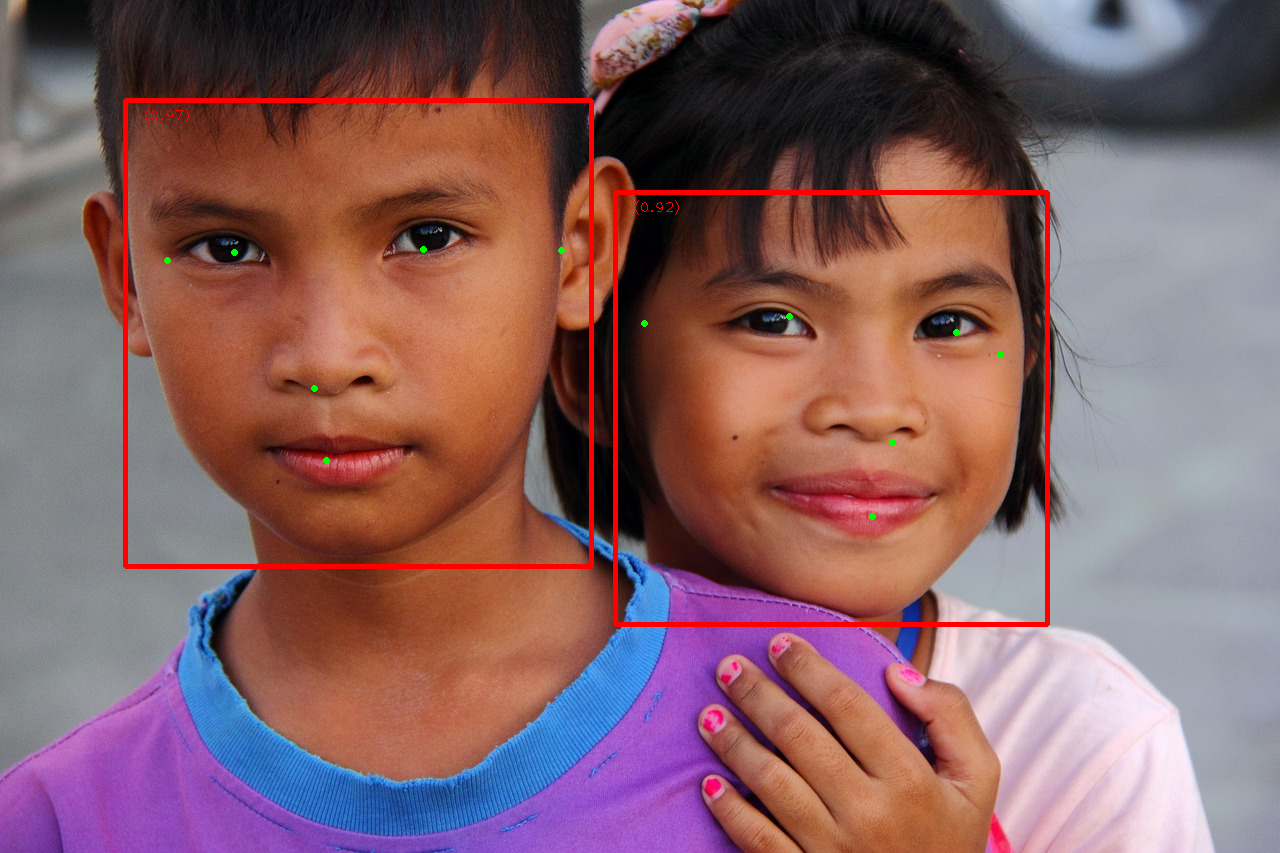

In [6]:
# STEP 1: Import the necessary modules.
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceDetector object.
base_options = python.BaseOptions(model_asset_path='detector.tflite')
options = vision.FaceDetectorOptions(base_options=base_options)
detector = vision.FaceDetector.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file(IMAGE_FILE)

# STEP 4: Detect faces in the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
image_copy = np.copy(image.numpy_view())
annotated_image = visualize(image_copy, detection_result)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
cv2_imshow(rgb_annotated_image)